In [1]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from torch import nn
import torch.optim as optim
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP
from nuscenes.prediction.models.covernet import CoverNet, ConstantLatticeLoss
import math
import pickle


In [2]:
# dataset_paths = [
#    "../data/record/Town10_2",
# ]

dataset_paths = []
records_folder = "D:/Workspace/Autopilot/data/record"
for name in os.listdir(records_folder):
   dir = os.path.join(records_folder, name)
   if os.path.isdir(dir):
      dataset_paths.append(dir)

print(dataset_paths)

['D:/Workspace/Autopilot/data/record\\Town01_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town01_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town02_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town02_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town03_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town03_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town04_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town04_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town05_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town05_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town06_100npcs_1', 'D:/Workspace/Autopilot/data/record\\Town06_100npcs_2', 'D:/Workspace/Autopilot/data/record\\Town06_200npcs_1', 'D:/Workspace/Autopilot/data/record\\Town06_200npcs_2', 'D:/Workspace/Autopilot/data/record\\Town12_2000npcs_1', 'D:/Workspace/Autopilot/data/record\\Town12_200npcs_2', 'D:/Workspace/Autopilot/data/record\\Town12_200npcs_3', 'D:/Workspace/Autopilot/data/record\\Town15_50

130809


C:\Users\IX\AppData\Local\Temp\ipykernel_54128\528964998.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])
104647 26162


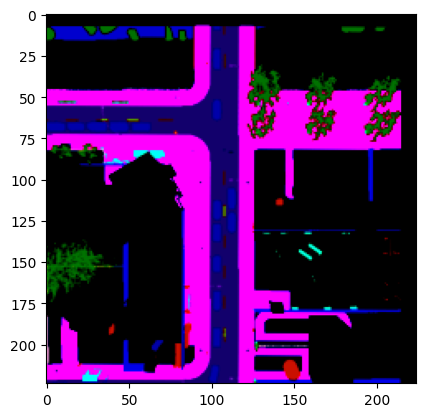

In [3]:
def rotate_points(points, angel):
    rotated = np.zeros(points.shape, dtype=points.dtype)
    rotated[...,0] = np.cos(np.deg2rad(angel)) * points[...,0] - np.sin(np.deg2rad(angel)) * points[...,1]
    rotated[...,1] = np.sin(np.deg2rad(angel)) * points[...,0] + np.cos(np.deg2rad(angel)) * points[...,1]
    return rotated

class BehaviorPredictionDataset(Dataset):
    def __init__(self, dataset_paths, return_metadata=False, transform=None, sensor_range=50.0, bev_range=50.0):
        super().__init__()
        self.records = []
        self.return_metadata = return_metadata
        self.transform = transform
        self.sensor_range = sensor_range
        self.bev_range = bev_range
        self.trajectory_length = 12
        self.frame_interval = 10        # Must match the dataset

        for path in dataset_paths:
            self.read_data_folder(path)
    
    def read_data_folder(self, path):
        local_records = []
        for agent in os.listdir(os.path.join(path, 'agents')):
            agent_folder = os.path.join(path, 'agents', agent)

            agent_location = {}
            for line in open(os.path.join(agent_folder, 'gt_location', 'data.jsonl'), 'r'):
                record = json.loads(line)
                agent_location[record['frame']] = {
                    'location': record['location'],
                    'rotation': record['rotation'],
                }

            vehicle_bbox_records = []
            vehicle_trajectories = {}
            for line in open(os.path.join(agent_folder, 'gt_vehicle_bbox', 'data.jsonl'), 'r'):
                record = json.loads(line)
                vehicle_bbox_records.append(record)
                frame = record['frame']
                for vehicle in record['vehicles']:
                    distance = np.linalg.norm(np.array(agent_location[frame]['location'])-np.array(vehicle['location']))
                    if distance > self.sensor_range:
                        continue
                    if vehicle['id'] not in vehicle_trajectories:
                        vehicle_trajectories[vehicle['id']] = {}
                    vehicle_trajectories[vehicle['id']][frame] = np.array(vehicle['location'])
                    local_records.append({
                        'vehicle_id': vehicle['id'],
                        'frame': frame,
                        'timestamp': record['timestamp'],
                        # 'current_action': vehicle['current_action'],
                        'distance': distance,
                        'agent_location': np.array(agent_location[frame]['location']),
                        'agent_rotation': np.array(agent_location[frame]['rotation']),
                        'vehicle_location': np.array(vehicle['location']),
                        'vehicle_rotation': np.array(vehicle['rotation']),
                        'vehicle_velocity': np.array(vehicle['velocity']),
                        'bev_image_path': os.path.join(agent_folder, 'birds_view_semantic_camera', str(frame)+'.png'),
                        'output_path': os.path.join(agent_folder, 'pred_vehicle_trajectory', 'data.jsonl'),
                    })
        
        records_to_delete = []
        for idx, record in enumerate(local_records):
            trajectory = []
            for f in range(record['frame'], record['frame'] + (self.trajectory_length * self.frame_interval), self.frame_interval):
                if f in vehicle_trajectories[record['vehicle_id']]:
                    trajectory.append(vehicle_trajectories[record['vehicle_id']][f])
                else:
                    records_to_delete.append(idx)
                    break
            record['trajectory'] = np.array(trajectory)

        local_records = [element for i,element in enumerate(local_records) if i not in records_to_delete]
        
        self.records.extend(local_records)
    
    def __len__(self):
        return len(self.records)
    
    def __getitem__(self, index):
        record = self.records[index]
        agent_image = cv2.imread(record['bev_image_path'])
        agent_image = cv2.cvtColor(agent_image, cv2.COLOR_BGR2RGB)
        vehicle_pitch = record['vehicle_rotation'][2]
        y = record['trajectory']
        vehicle_velocity = rotate_points(record['vehicle_velocity'], -vehicle_pitch)
        state_vector = vehicle_velocity
        width = agent_image.shape[1]
        height = agent_image.shape[0]
        assert agent_image.shape[0] == agent_image.shape[1]
        img_scale =  agent_image.shape[0] / (self.bev_range*2)
        
        image = agent_image
        # Rotate the image to standard rotation
        agent_pitch = record['agent_rotation'][2]
        # print(agent_pitch)
        mat = cv2.getRotationMatrix2D((width/2, height/2), -agent_pitch, 1.0)
        image = cv2.warpAffine(src=agent_image, M=mat, dsize=(width, height))

        translation = record['vehicle_location'] - record['agent_location']
        # Move the vehicle to the center
        translation_matrix = np.array([
            [1, 0, -translation[1]*img_scale],
            [0, 1, translation[0]*img_scale]
        ], dtype=np.float32)

        image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height))
        
        # print(translation[0], translation[1])
        # print(translation[0]*img_scale, translation[1]*img_scale)

        
        # print(vehicle_pitch)
        mat = cv2.getRotationMatrix2D((width/2, height/2), vehicle_pitch, 1.0)
        image = cv2.warpAffine(src=image, M=mat, dsize=(width, height))

        # print(record['vehicle_id'])

        if self.transform is not None:
            image = self.transform(image)

        image = torch.tensor(image, dtype=torch.float32)
        state_vector = torch.tensor(state_vector, dtype=torch.float32)
        y = np.array(y)
        y = (y-record['vehicle_location'])[:, [0, 1]] # take relative x and y coordinate
        
        y = rotate_points(y, -vehicle_pitch)
        y = torch.tensor(y, dtype=torch.float32)

        if self.return_metadata:
            return image, state_vector, y, self.records[index]
        return image, state_vector, y

preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = BehaviorPredictionDataset(dataset_paths, transform=preprocess)

print(len(dataset))
img, state_vector, y = dataset[1840]
plt.imshow(np.array(img).transpose(1, 2, 0))
print(y)

train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
print(train_size, test_size)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(233))

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0,
)


In [4]:
from typing import List, Tuple, Callable, Union

import numpy as np
import torch
from torch import nn

def mean_pointwise_l2_distance(lattice: torch.Tensor, ground_truth: torch.Tensor) -> torch.Tensor:
    """
    Computes the index of the closest trajectory in the lattice as measured by l1 distance.
    :param lattice: Lattice of pre-generated trajectories. Shape [num_modes, n_timesteps, state_dim]
    :param ground_truth: Ground truth trajectory of agent. Shape [1, n_timesteps, state_dim].
    :return: Index of closest mode in the lattice.
    """
    stacked_ground_truth = ground_truth.repeat(lattice.shape[0], 1, 1)
    return torch.pow(lattice - stacked_ground_truth, 2).sum(dim=2).sqrt().mean(dim=1).argmin()


class ConstantLatticeLoss:
    """
    Computes the loss for a constant lattice CoverNet model.
    """

    def __init__(self, lattice: Union[np.ndarray, torch.Tensor],
                 similarity_function: Callable[[torch.Tensor, torch.Tensor], int] = mean_pointwise_l2_distance):
        """
        Inits the loss.
        :param lattice: numpy array of shape [n_modes, n_timesteps, state_dim]
        :param similarity_function: Function that computes the index of the closest trajectory in the lattice
            to the actual ground truth trajectory of the agent.
        """

        self.lattice = torch.Tensor(lattice)
        self.similarity_func = similarity_function

    def __call__(self, batch_logits: torch.Tensor, batch_ground_truth_trajectory: torch.Tensor) -> torch.Tensor:
        """
        Computes the loss on a batch.
        :param batch_logits: Tensor of shape [batch_size, n_modes]. Output of a linear layer since this class
            uses nn.functional.cross_entropy.
        :param batch_ground_truth_trajectory: Tensor of shape [batch_size, 1, n_timesteps, state_dim]
        :return: Average element-wise loss on the batch.
        """

        # If using GPU, need to copy the lattice to the GPU if haven't done so already
        # This ensures we only copy it once
        if self.lattice.device != batch_logits.device:
            self.lattice = self.lattice.to(batch_logits.device)

        batch_losses = torch.Tensor().requires_grad_(True).to(batch_logits.device)
        batch_acc = torch.Tensor().requires_grad_(True).to(batch_logits.device)

        for logit, ground_truth in zip(batch_logits, batch_ground_truth_trajectory):

            closest_lattice_trajectory = self.similarity_func(self.lattice, ground_truth)
            label = torch.LongTensor([closest_lattice_trajectory]).to(batch_logits.device)
            classification_loss = torch.nn.functional.cross_entropy(logit.unsqueeze(0), label)
            pred_label = torch.argmax(logit.unsqueeze(0), dim=1)
            accuracy = (pred_label == label).float()

            batch_losses = torch.cat((batch_losses, classification_loss.unsqueeze(0)), 0)
            batch_acc = torch.cat((batch_acc, accuracy.unsqueeze(0)), 0)
        
        return batch_losses.mean(), batch_acc.mean()


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

backbone = ResNetBackbone('resnet50')

with open('../tmp/nuscenes-prediction-challenge-trajectory-sets/epsilon_2.pkl', 'rb') as f:
    lattice = pickle.load(f)
    # In our data the vehicle is heading to the x axis, but the lattice is assuming the vehicle
    # is heading toward y axis, so we need to rotate these -90 degrees.
    lattice = rotate_points(np.array(lattice), -90)

print('len(lattice):', len(lattice))

# Note that the value of num_modes depends on the size of the lattice used for CoverNet.
lattice = np.array(lattice)
model = CoverNet(backbone, num_modes=lattice.shape[0], input_shape=(3,224,224))
model.to(device)

criterion = ConstantLatticeLoss(lattice)
#optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=0)

save_dir = '../tmp/TrajectoryPrediction/resnet50_epsilon_2/'
os.makedirs(save_dir, exist_ok=True)


cuda
len(lattice): 2206


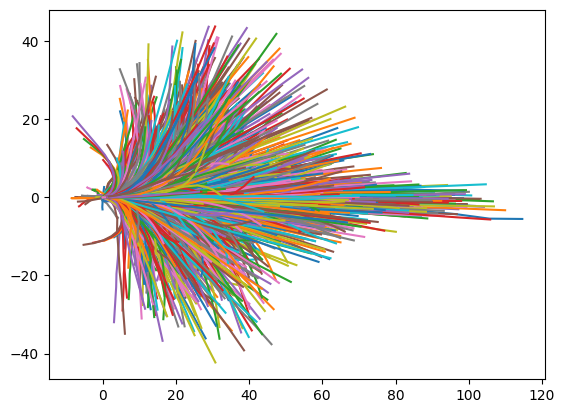

In [6]:
for l in lattice:
    plt.plot(l[:, 0], l[:, 1])
plt.show()

C:\Users\IX\AppData\Local\Temp\ipykernel_54128\528964998.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


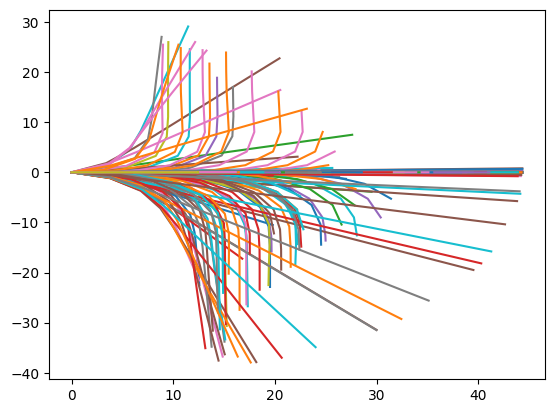

In [7]:
for i in range(1000):
    img, state_vector, y = dataset[i]
    plt.plot(y[:, 0], y[:, 1])
plt.show()

In [8]:
# Load existing model

try:
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth')))
    optimizer.load_state_dict(torch.load(os.path.join(save_dir, 'optimizer.pth')))
except Exception as e:
    print(e)

[Errno 2] No such file or directory: '../tmp/TrajectoryPrediction/resnet50_epsilon_2/model.pth'


In [9]:
try:
    model.load_state_dict(torch.load(os.path.join(save_dir, 'model_29.pth')))
    optimizer.load_state_dict(torch.load(os.path.join(save_dir, 'optimizer_29.pth')))
except Exception as e:
    print(e)

In [10]:
label_counts = {}
for i, data in enumerate(train_loader):
    image, state_vector, trajectory = data

    for ground_truth in trajectory:
        closest_lattice_trajectory = mean_pointwise_l2_distance(torch.tensor(lattice), ground_truth)
        label = int(closest_lattice_trajectory)
        if label not in label_counts:
            label_counts[label] = 1
        else:
            label_counts[label] += 1

print(label_counts)


C:\Users\IX\AppData\Local\Temp\ipykernel_54128\528964998.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


{257: 64133, 852: 41, 48: 878, 10: 29, 242: 1, 17: 237, 280: 602, 460: 278, 28: 615, 12: 187, 205: 720, 204: 2587, 1788: 645, 296: 478, 1937: 1210, 849: 476, 163: 142, 134: 72, 2129: 40, 857: 26, 30: 3, 417: 14, 1640: 228, 0: 1277, 41: 57, 637: 51, 26: 1187, 299: 16, 2: 33, 563: 1553, 1271: 90, 1702: 985, 69: 51, 891: 74, 25: 1213, 1002: 8, 894: 94, 758: 321, 1: 935, 868: 53, 480: 29, 27: 578, 64: 178, 334: 227, 2187: 437, 1268: 384, 1203: 172, 893: 453, 1512: 49, 643: 98, 1144: 155, 77: 3, 918: 122, 965: 263, 966: 49, 1488: 132, 822: 35, 1759: 43, 406: 51, 1900: 309, 1157: 28, 850: 650, 392: 61, 1054: 59, 906: 135, 67: 188, 518: 41, 457: 30, 39: 42, 125: 9, 1852: 29, 162: 201, 254: 436, 493: 77, 1867: 9, 489: 45, 2173: 30, 11: 65, 1071: 71, 1406: 3, 1264: 25, 250: 85, 1265: 151, 1863: 25, 862: 66, 1885: 4, 4: 60, 1059: 17, 1643: 93, 76: 59, 36: 141, 7: 107, 229: 132, 246: 7, 1776: 21, 774: 32, 626: 60, 43: 118, 1058: 22, 133: 157, 5: 47, 1642: 102, 19: 39, 851: 26, 755: 171, 350: 14, 

In [11]:
num_epochs = 30
model.train()
for epoch in range(0, num_epochs):
    train_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(train_loader):
        image, state_vector, trajectory = data
        image = image.to(device)
        state_vector = state_vector.to(device)
        trajectory = trajectory.to(device)
        optimizer.zero_grad()
        logits = model(image, state_vector)

        loss, acc = criterion(logits, trajectory)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += acc.item()
    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    print(f'Epoch {epoch} training loss: {train_loss} acc: {train_acc}')

    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        for i, data in enumerate(test_loader):
            image, state_vector, trajectory = data
            image = image.to(device)
            state_vector = state_vector.to(device)
            trajectory = trajectory.to(device)
            logits = model(image, state_vector)

            loss, acc = criterion(logits, trajectory)
            test_loss += loss.item()
            test_acc += acc.item()
        test_loss = test_loss / len(test_loader)
        test_acc = test_acc / len(test_loader)
        print(f'Epoch {epoch} testing loss: {test_loss} acc: {test_acc}')
    
    if (epoch+1) % 2 == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_{epoch}.pth'))
        torch.save(optimizer.state_dict(), os.path.join(save_dir, f'optimizer_{epoch}.pth'))


C:\Users\IX\AppData\Local\Temp\ipykernel_54128\528964998.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Epoch 0 training loss: 7.698936462693809 acc: 0.012274056937190315
Epoch 0 testing loss: 7.698936462402344 acc: 0.012797982885085575
Epoch 1 training loss: 7.698936462693809 acc: 0.012196286674816625
Epoch 1 testing loss: 7.698936462402344 acc: 0.012797982885085575


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    test_loss = 0.0
    test_acc = 0.0
    test_correct = 0.0
    for i, data in enumerate(test_loader):
        image, state_vector, trajectory = data
        image = image.to(device)
        state_vector = state_vector.to(device)
        trajectory = trajectory.to(device)
        logits = model(image, state_vector)

        loss, acc = criterion(logits, trajectory)
        test_loss += loss.item()
        test_acc += acc.item()
    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(test_loader)
    print(f'Testing loss: {test_loss}')
    print(f'Testing acc: {test_acc}')


C:\Users\IX\AppData\Local\Temp\ipykernel_48132\2344125129.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


Testing loss: 1.8246688905436643
Testing acc: 0.6576915340817467


C:\Users\IX\AppData\Local\Temp\ipykernel_55260\2344125129.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


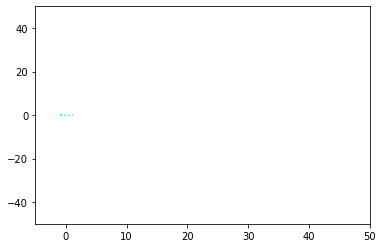

In [ ]:
os.makedirs(os.path.join(save_dir, 'results'), exist_ok=True)
import matplotlib
cmap = matplotlib.cm.get_cmap('hsv')

test_loader_2 = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

model.eval()

for bi, data in enumerate(test_loader_2):
    image, state_vector, trajectory = data
    image = image.to(device)
    state_vector = state_vector.to(device)
    trajectory = trajectory.to(device)
    logits = model(image, state_vector)
    loss, acc = criterion(logits, trajectory)
    with torch.no_grad():
        logits = model(image, state_vector)
        _, predictions = torch.max(logits, 1)
        predictions = predictions.detach().cpu().numpy()
    pred_trajectory = lattice[predictions]
    
    # print(image.shape)
    # print(state_vector.shape)
    # print(trajectory.shape)
    # print(pred_trajectory.shape)

    trajectory = trajectory.cpu().numpy()
    color_norm = matplotlib.colors.Normalize(vmin=-1, vmax=trajectory.shape[0])
    plt.clf()
    plt.xlim(-5, 50)
    plt.ylim(-50, 50)
    for i in range(trajectory.shape[0]):
        tj = trajectory[i]
        plt.plot(tj[:, 0], tj[:, 1], color=cmap(color_norm(i)))

    for i in range(pred_trajectory.shape[0]):
        tj = pred_trajectory[i]
        plt.plot(tj[:, 0], tj[:, 1], ':', color=cmap(color_norm(i)), alpha=1)
    #plt.show()
    plt.savefig(os.path.join(save_dir, 'results', f'compare_{bi}'))

    if bi == 1000:
        break


In [ ]:
# Save the models

torch.save(model.state_dict(), os.path.join(save_dir, 'model.pth'))
torch.save(optimizer.state_dict(), os.path.join(save_dir, 'optimizer.pth'))

In [ ]:
# def write_pred():
#     dataset = BehaviorPredictionDataset(dataset_paths, return_metadata=True, transform=preprocess)
#     dataloader = DataLoader(
#         dataset,
#         batch_size=64,
#         shuffle=False,
#     )

#     save_objs = {}

#     total_loss = 0.0
#     total_samples = 0.0
#     total_correct = 0.0
#     for i, data in enumerate(dataloader):
#         image, state_vector, trajectory, meta = data
#         image = image.to(device)
#         state_vector = state_vector.to(device)
#         trajectory = trajectory.to(device)

#         logits = model(image, state_vector)
#         loss, acc = criterion(logits, trajectory)

#         with torch.no_grad():
#             _, predictions = torch.max(logits, 1)
#             predictions = predictions.detach().cpu().numpy()
#             pred_trajectory = lattice[predictions]
#             trajectory = trajectory.detach().cpu().numpy()

#         for i in range(trajectory.shape[0]):
#             output_path = meta['output_path'][i]
#             if output_path not in save_objs:
#                 save_objs[output_path] = {}
#             frame = int(meta['frame'][i])
#             if frame not in save_objs[output_path]:
#                 save_objs[output_path][frame] = {}
#             save_objs[output_path][frame][meta['vehicle_id'][i]] = {
#                 'id': meta['vehicle_id'][i],
#                 'frame': int(meta['frame'][i]),
#                 'timestamp': float(meta['timestamp'][i]),
#                 'location': meta['vehicle_location'][i].tolist(),
#                 'rotation': meta['vehicle_rotation'][i].tolist(),
#                 'trajectory': np.array(pred_trajectory).tolist(),
#                 'trajectory_gt': np.array(trajectory).tolist(),
#             }

#         total_loss += loss.item()
#     total_loss = total_loss / len(dataloader)
#     print(f'Average loss: {total_loss}')

#     for filepath, frames in save_objs.items():
#         os.makedirs(os.path.dirname(filepath), exist_ok=True)
#         with open(filepath, 'w') as file:
#             for frame in sorted(list(frames.keys())):
#                 line = json.dumps(save_objs[filepath][frame])
#                 file.write(line+"\n")

# write_pred()